<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [2]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [3]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Current device = {device}")
!nvidia-smi

CUDA is available!  Training on GPU ...
Current device = cuda
Mon Dec 18 08:01:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                          

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [4]:
import random
SEED = 42
RANDOM_STATE = SEED
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
!conda install -y gdown 
!gdown --id 1GSNBqsyg_dQRkkzaB0UMJuY3tyjoE3xm

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    filelock-3.13.1            |     pyhd8ed1ab_0          15 KB  conda-forge
    gdown-4.7.1                |     pyhd8ed1ab_0          19 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          34 KB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.13.1-pyhd8ed1ab_0

In [6]:
from pathlib import Path
#os.makedirs('/kaggle/working/GAN')
#GDD = Path('/kaggle/working/GAN')
GDD = Path('/kaggle/input/my-gan')

In [7]:
import zipfile
DATA = Path('/kaggle/working/faces_dataset_small')
file_path = '/kaggle/working/archive.zip'
extract_path = '/kaggle/working/'

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

extracted_files = os.listdir(extract_path)

In [8]:
image_files = sorted(list(DATA.rglob('*.png')))
len(image_files)

3143

In [9]:
from torch.utils.data import Dataset
from torchvision import transforms, models
from PIL import Image, ImageDraw

In [10]:
class FacesDataset(Dataset):

    def __init__(self, files, rescale_size):
        super().__init__()
        self.files = sorted(files)
        self.rescale_size = rescale_size
        self.len_ = len(self.files)
        self.base_transforms = transforms.Compose([
            transforms.Resize(self.rescale_size),
            transforms.CenterCrop(self.rescale_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

        self.dataset = torch.empty(size=(self.len_, 3, self.rescale_size, self.rescale_size))
        for i, image_path in enumerate(self.files):
            image = Image.open(image_path)
            self.dataset[i] = self.base_transforms(image)

    def __len__(self):
        return self.len_

    def __getitem__(self, index):
        transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5)])
        x = self.dataset[index]
        x = transform(x)
        return x

In [11]:
# global perameters
n_epochs = 350
batch_size = 128
lr = 1e-4
b1 = 0.5
b2 = 0.999
workers = 2
nz = 128 # size of latent vector z
nc = 3 # number of image channels
ngf = 64 # size of feature maps in generator
ndf = 64 # size of features maps in discriminator
kernel_size = 4
image_size = 128
batchNorm_momentum = 0.1

In [12]:
dataset = FacesDataset(image_files, rescale_size=image_size)
data_loader = DataLoader(dataset, pin_memory=False, batch_size=batch_size, shuffle=True,
                         num_workers=workers)

In [13]:
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [14]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [15]:
def to_device(data, device):
    # tensor device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [16]:
def show_images(images, nmax=32):
    fig, ax = plt.subplots(figsize=(12, 24))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    plt.title('')

def show_batch(dl, nmax=32):
    for images in dl:
        show_images(images, nmax)
        break

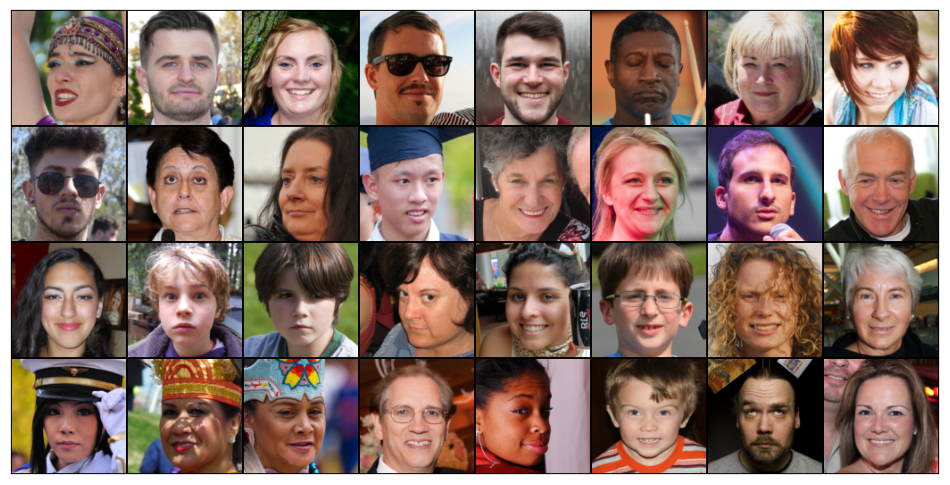

In [17]:
show_batch(data_loader)

In [18]:
class Noise(nn.Module):

    def __init__(self, std):
        super().__init__()
        self.std = std

    def forward(self, x):
        if self.training:
            return x + torch.empty_like(x).normal_(std=self.std)
        else:
            return x

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [19]:
class Discriminator(nn.Module):
  def __init__(self, std=0.06):
    super(Discriminator, self).__init__()
    self.std = std

    self.seq = nn.Sequential(
        # input
        Noise(self.std),
        nn.Conv2d(in_channels=nc, out_channels=ndf, kernel_size=kernel_size, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),

        Noise(self.std),
        nn.Conv2d(in_channels=ndf, out_channels=ndf * 2, kernel_size=kernel_size, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=ndf *2, momentum = batchNorm_momentum),
        nn.LeakyReLU(0.2, inplace=True),

        Noise(self.std),
        nn.Conv2d(in_channels=ndf * 2, out_channels=ndf * 4, kernel_size=kernel_size, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=ndf * 4, momentum = batchNorm_momentum),
        nn.LeakyReLU(0.2, inplace=True),

        Noise(self.std),
        nn.Conv2d(in_channels=ndf * 4, out_channels=ndf * 8, kernel_size=kernel_size, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=ndf * 8, momentum = batchNorm_momentum),
        nn.LeakyReLU(0.2, inplace=True),

        Noise(self.std),
        nn.Conv2d(in_channels=ndf * 8, out_channels=ndf * 16, kernel_size=kernel_size, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=ndf * 16, momentum = batchNorm_momentum),
        nn.LeakyReLU(0.2, inplace=True),

        # output
        Noise(self.std),
        nn.Conv2d(in_channels=ndf * 16, out_channels=1, kernel_size=kernel_size, stride=1, padding=0, bias=False),
        nn.Flatten(),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.seq(x)

In [20]:
def weights_init(m):

    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [29]:
!pip install torchinfo
from torchinfo import summary
summary(Discriminator().to('cpu').apply(weights_init), (batch_size, nc, image_size, image_size))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [128, 1]                  --
├─Sequential: 1-1                        [128, 1]                  --
│    └─Noise: 2-1                        [128, 3, 128, 128]        --
│    └─Conv2d: 2-2                       [128, 64, 64, 64]         3,072
│    └─LeakyReLU: 2-3                    [128, 64, 64, 64]         --
│    └─Noise: 2-4                        [128, 64, 64, 64]         --
│    └─Conv2d: 2-5                       [128, 128, 32, 32]        131,072
│    └─BatchNorm2d: 2-6                  [128, 128, 32, 32]        256
│    └─LeakyReLU: 2-7                    [128, 128, 32, 32]        --
│    └─Noise: 2-8                        [128, 128, 32, 32]        --
│    └─Conv2d: 2-9                       [128, 256, 16, 16]        524,288
│    └─BatchNorm2d: 2-10                 [128, 256, 16, 16]        512
│    └─LeakyReLU: 2-11                   [128, 256, 16, 16]        --


In [21]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.nz = nz

    self.seq = nn.Sequential(
        # input Z
        nn.ConvTranspose2d(in_channels=nz, out_channels=ngf * 16, kernel_size=kernel_size, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(num_features=ngf*16, momentum = batchNorm_momentum),
        nn.LeakyReLU(0.2, inplace=True),

        nn.ConvTranspose2d(in_channels=ngf * 16, out_channels=ngf * 8, kernel_size=kernel_size, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=ngf*8, momentum = batchNorm_momentum),
        nn.LeakyReLU(0.2, inplace=True),

        nn.ConvTranspose2d(in_channels=ngf*8, out_channels=ngf*4, kernel_size=kernel_size, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=ngf*4, momentum = batchNorm_momentum),
        nn.LeakyReLU(0.2, inplace=True),

        nn.ConvTranspose2d(in_channels=ngf * 4, out_channels=ngf*2, kernel_size=kernel_size, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=ngf*2, momentum = batchNorm_momentum),
        nn.LeakyReLU(0.2, inplace=True),

        nn.ConvTranspose2d(in_channels=ngf*2, out_channels=ngf, kernel_size=kernel_size, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=ngf, momentum = batchNorm_momentum),
        nn.LeakyReLU(0.2, inplace=True),

        # output nc * 64 * 64
        nn.ConvTranspose2d(in_channels=ngf, out_channels=nc, kernel_size=kernel_size, stride=2, padding=1, bias=False),
        nn.Tanh()
    )

  def forward(self, x):
    return self.seq(x)

In [31]:
from torchinfo import summary
summary(Generator().to('cpu').apply(weights_init), (batch_size, Generator().nz, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [128, 3, 128, 128]        --
├─Sequential: 1-1                        [128, 3, 128, 128]        --
│    └─ConvTranspose2d: 2-1              [128, 1024, 4, 4]         2,097,152
│    └─BatchNorm2d: 2-2                  [128, 1024, 4, 4]         2,048
│    └─LeakyReLU: 2-3                    [128, 1024, 4, 4]         --
│    └─ConvTranspose2d: 2-4              [128, 512, 8, 8]          8,388,608
│    └─BatchNorm2d: 2-5                  [128, 512, 8, 8]          1,024
│    └─LeakyReLU: 2-6                    [128, 512, 8, 8]          --
│    └─ConvTranspose2d: 2-7              [128, 256, 16, 16]        2,097,152
│    └─BatchNorm2d: 2-8                  [128, 256, 16, 16]        512
│    └─LeakyReLU: 2-9                    [128, 256, 16, 16]        --
│    └─ConvTranspose2d: 2-10             [128, 128, 32, 32]        524,288
│    └─BatchNorm2d: 2-11                 [128, 128, 

In [32]:
data_loader = DeviceDataLoader(data_loader, device)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [73]:
model = {
    "discriminator": Discriminator().to(device).apply(weights_init),
    "generator": Generator().to(device).apply(weights_init)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

optimizer = {
    "discriminator": torch.optim.AdamW(model["discriminator"].parameters(),
                                      lr=lr*1, betas=(b1, b2),
                                      eps=1e-8, weight_decay=1e-5, amsgrad=False),
    "generator": torch.optim.AdamW(model["generator"].parameters(),
                                  lr=lr*1.9, betas=(b1,b2),
                                  eps=1e-8, weight_decay=1e-5, amsgrad=False)
    }

In [22]:
from matplotlib.gridspec import GridSpec
from IPython.display import clear_output

In [58]:
def fit(model, criterion, epochs, optimizer, start_idx=1):

    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    schedulerD = torch.optim.lr_scheduler.MultiStepLR(optimizer["discriminator"], milestones=[epochs//8,epochs//3.9,epochs//2.1,epochs//1.6,epochs//1.3,epochs//1.2], gamma=0.55)
    schedulerG = torch.optim.lr_scheduler.MultiStepLR(optimizer["generator"], milestones=[epochs//8,epochs//3.9,epochs//2.1,epochs//1.6,epochs//1.3,epochs//1.2], gamma=0.55)

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images in tqdm(data_loader):
            
            optimizer["discriminator"].zero_grad()
            # pass real 
            real_preds = model["discriminator"](real_images)
            real_targets = 0.05 * torch.rand(real_images.size(0), 1, device=device) + 0.95 # вероятность от 0.9 до 1. LabelSmoothing
            #real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # generate fake 
            latent = torch.randn(batch_size, model["generator"].nz, 1, 1, device=device)
            fake_images = model["generator"](latent)
            # Pass fake images through discriminator
            fake_targets = 0.05 * torch.rand(fake_images.size(0), 1, device=device)  # вероятность от 0 до 0.1. LabelSmoothing
            #fake_targets = torch.zeros(fake_images.size(0), 1, device=device)  
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            optimizer["generator"].zero_grad()

            # generate fake
            latent = torch.randn(batch_size, model["generator"].nz, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)

            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())


        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        schedulerD.step()
        schedulerG.step()

        clear_output(wait=True)

        fig = plt.figure(figsize=(10, 5))
        fig.suptitle(("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch+1, epochs, losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1])))

        gs1 = GridSpec(2, 5, left=0.0001, right=0.95, wspace=0.05)

        ax1 = fig.add_subplot(gs1[:-1, :1])
        ax1.imshow(denorm(fake_images[0].detach().cpu().permute(1,2,0)))
        ax1.axis('off')
        ax2 = fig.add_subplot(gs1[:-1, 1])
        ax2.imshow(denorm(fake_images[1].detach().cpu().permute(1,2,0)))
        ax2.axis('off')
        ax3 = fig.add_subplot(gs1[:-1, 2])
        ax3.imshow(denorm(fake_images[2].detach().cpu().permute(1,2,0)))
        ax3.axis('off')
        ax4 = fig.add_subplot(gs1[:-1, 3])
        ax4.imshow(denorm(fake_images[3].detach().cpu().permute(1,2,0)))
        ax4.axis('off')
        ax5 = fig.add_subplot(gs1[:-1, -1])
        ax5.imshow(denorm(fake_images[4].detach().cpu().permute(1,2,0)))
        ax5.axis('off')
        ax6 = fig.add_subplot(gs1[-1, :1])
        ax6.imshow(denorm(fake_images[5].detach().cpu().permute(1,2,0)))
        ax6.axis('off')
        ax7 = fig.add_subplot(gs1[-1, 1])
        ax7.imshow(denorm(fake_images[6].detach().cpu().permute(1,2,0)))
        ax7.axis('off')
        ax8 = fig.add_subplot(gs1[-1, 2])
        ax8.imshow(denorm(fake_images[7].detach().cpu().permute(1,2,0)))
        ax8.axis('off')
        ax9 = fig.add_subplot(gs1[-1, 3])
        ax9.imshow(denorm(fake_images[8].detach().cpu().permute(1,2,0)))
        ax9.axis('off')
        ax10 = fig.add_subplot(gs1[-1, 4])
        ax10.imshow(denorm(fake_images[9].detach().cpu().permute(1,2,0)))
        ax10.axis('off')

        gs2 = GridSpec(2, 2, left=1.01, right=2.0, hspace=0.05)

        ax11 = fig.add_subplot(gs2[:, :-1])
        ax11.plot(np.arange(len(losses_g)), losses_g, label='Generator')
        ax11.plot(np.arange(len(losses_d)), losses_d, label='Discriminator')
        ax11.set_ylim(0, max(losses_g+losses_g)+0.5)
        ax11.set_xlabel('Epoch')
        ax11.set_title('Losses')
        ax11.legend()

        plt.show()

    return losses_g, losses_d, real_scores, fake_scores

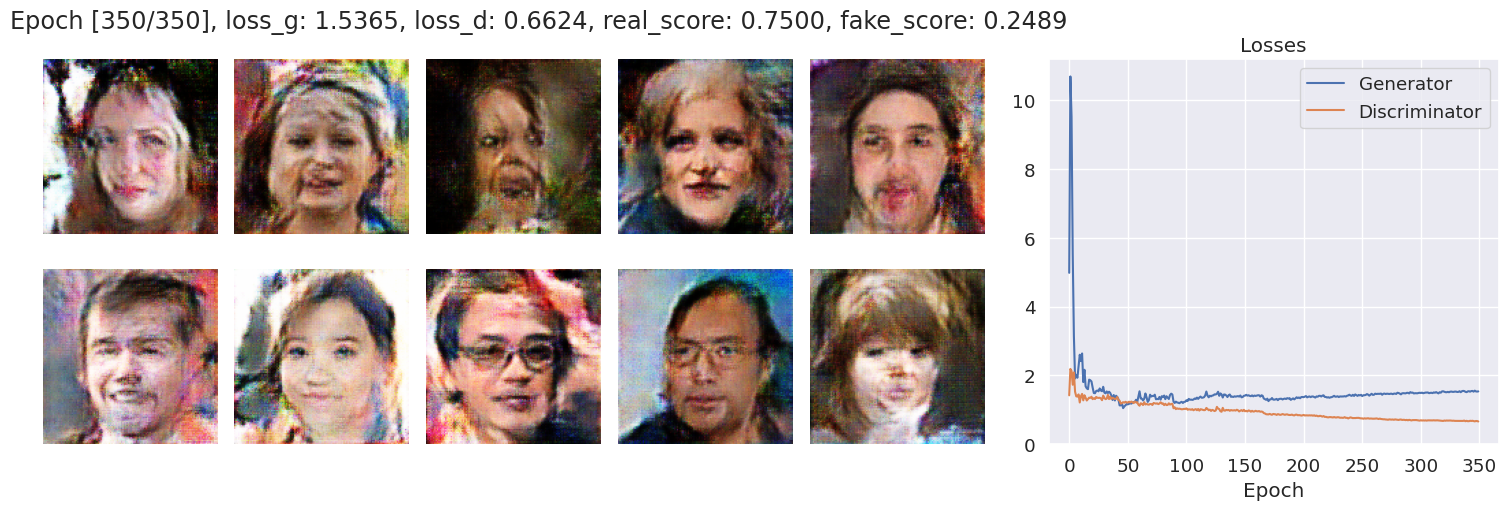

In [74]:
history = fit(model, criterion, n_epochs, optimizer)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

**Лоссс-функция генератора больше значений лосс-функции дискриминатора, значения генератора поначалу стремятся приблизиться к значениям дискриминатора, но потом дискриминатор начинает медленно побеждать и постепенно убывать(с уменьшением learning rate при помощи MultiStelLr), а генератор начинает потихоньку возрастать. Лосс-функция дискриминатора более стабильна**

In [75]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
torch.save(model["generator"].state_dict(), Path(str(GDD) + str('/generator.pt')))
torch.save(model["discriminator"].state_dict(), Path(str(GDD) + str('/discriminator.pt')))

In [23]:
model = {
    "discriminator": Discriminator().to(device).apply(weights_init),
    "generator": Generator().to(device).apply(weights_init)
}

model["discriminator"].load_state_dict(torch.load(Path(str(GDD) + str('/discriminator.pt')), map_location=torch.device('cuda')))
model["discriminator"].eval()

Discriminator(
  (seq): Sequential(
    (0): Noise()
    (1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Noise()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Noise()
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Noise()
    (12): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.2, inplace=True)
    (15): Noise()
    (16): Conv2d(512, 1024, kernel_size

In [24]:
model["generator"].load_state_dict(torch.load(Path(str(GDD) + str('/generator.pt')), map_location=torch.device('cuda')))
model["generator"].eval()

Generator(
  (seq): Sequential(
    (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): ConvT

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [80]:
n_images = 64                                                                              # Количество генерируемых изображений
fixed_latent = torch.randn(n_images, model["generator"].nz, 1, 1, device=device)           # Создадим латентный вектор
fake_images = model["generator"](fixed_latent)

In [37]:
def show_images(fake_images):
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(fake_images.cpu().detach()), nrow=12).permute(1, 2, 0))

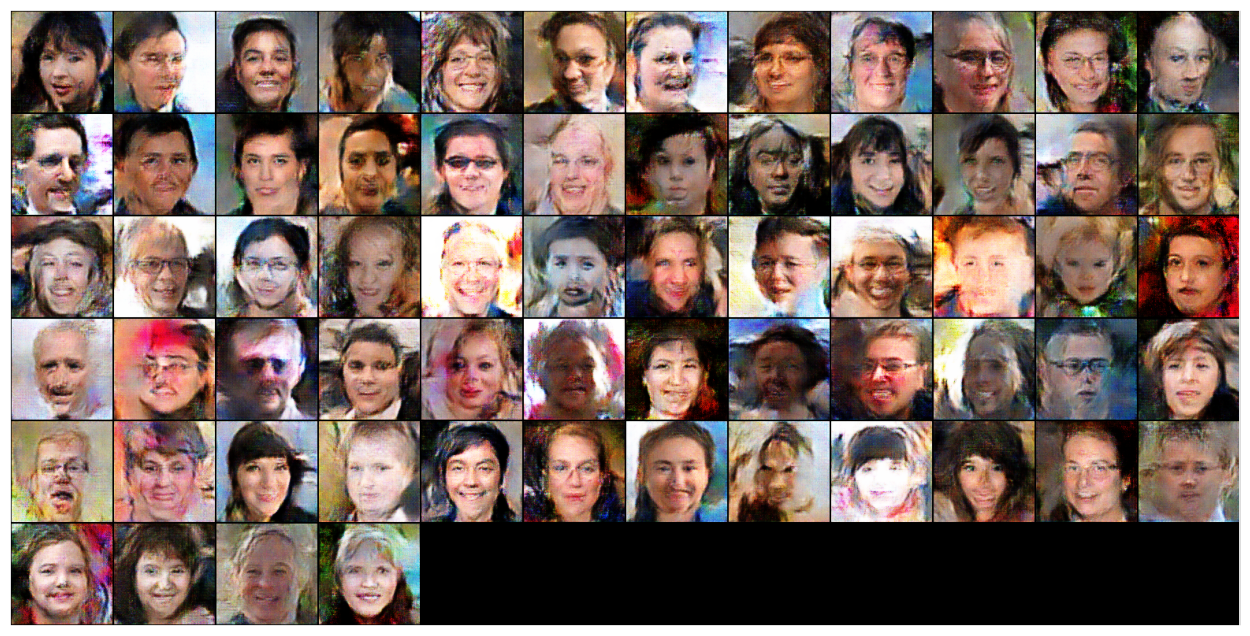

In [82]:
show_images(fake_images)

Как вам качество получившихся изображений?

**Лица неплохо похожи на человеческие, фон обрабатывается не слишком хорошо, но такие детали как очки генерируются неплохо**

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import LeaveOneOut
from sklearn.manifold import TSNE

# Подготовка реальных изображений
real_images_all = torch.FloatTensor()
iterator = iter(data_loader)
for i in tqdm(range(len(data_loader))):
    real_images_all = torch.cat((real_images_all, next(iterator).cpu()))
real_ones = torch.ones(dataset.len_, 1, device=device)  # Метки класса 1

# Подготовка фейковых изображений
model["generator"].eval()
with torch.no_grad():
    fake_images_all = model["generator"](torch.randn(dataset.len_, nz, 1, 1, device=device))
fake_zero = torch.zeros(dataset.len_, 1, device=device) # Метки класса 0

  0%|          | 0/25 [00:00<?, ?it/s]

In [26]:
real_with_fake_images = torch.cat((real_images_all.to('cpu'), fake_images_all.to('cpu')))
n_img = real_with_fake_images.shape[0]
real_with_fake_images = real_with_fake_images.reshape(n_img,-1).numpy() #создадим плоский вектор
real_with_fake_labels = torch.cat((real_ones.to('cpu'), fake_zero.to('cpu'))).numpy().ravel()

In [ ]:
clf = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
loo = LeaveOneOut()
accuracy_list = []
classes_list = []
for train_index, test_index in loo.split(real_with_fake_images):
    X_train, X_test = real_with_fake_images[train_index], real_with_fake_images[test_index]
    y_train, y_test = real_with_fake_labels[train_index], real_with_fake_labels[test_index]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list.append(accuracy)
    classes_list.append(y_test)

In [87]:
import pandas as pd
df = pd.DataFrame()
df['accuracy'] = accuracy_list
df['accuracy'] = df['accuracy'].astype('int32')
df['classes'] = classes_list
df['classes'] = df['classes'].astype('int32')
df.pivot_table(values='accuracy', index='classes', aggfunc='mean')

accuracy
classes          
0        0.437480
1        0.802418

In [89]:
round(df['accuracy'].mean(),2)

0.62

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

**Многие изображения, которые мы генерируем моделью из шума, распознаются как реальные. Что видно из визуализациии. Настоящие фото в основном распознаются тоже как реальные, что говорит о том, что сгенерированные изображения хороши. При этом, accuracy, которую мы бы хотели получить, равна 0.5. Полученное значение accuracy 0.62 достаточно близко к 0.5**

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [40]:
import warnings
warnings.filterwarnings("ignore")

real_with_fake_images_tsne = TSNE(n_components=2).fit_transform(real_with_fake_images)

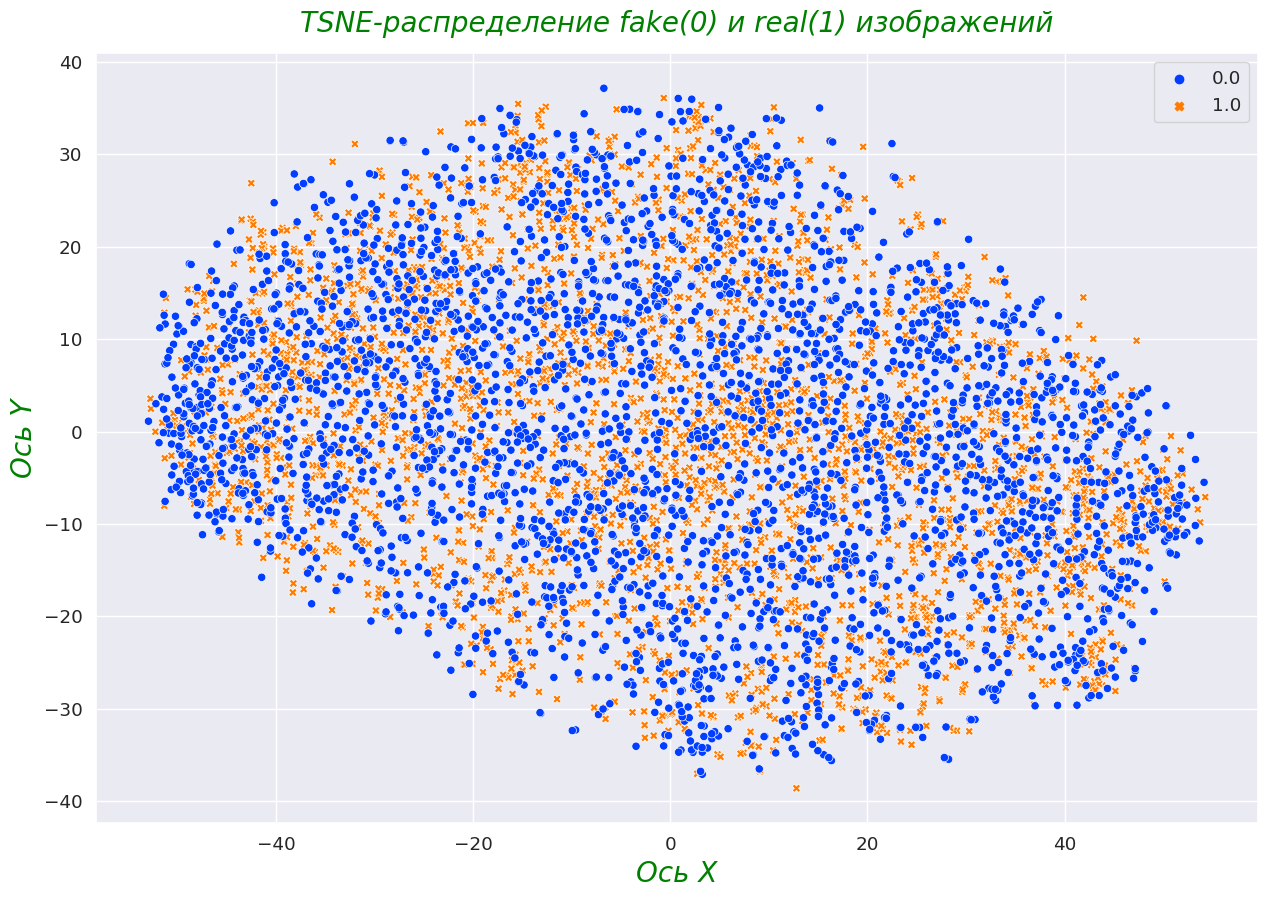

In [42]:
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize': (17, 12)}, font_scale=1.2, style='darkgrid')
sns.scatterplot(x = real_with_fake_images_tsne[:, 0], y = real_with_fake_images_tsne[:, 1], hue=real_with_fake_labels, palette='bright', style=real_with_fake_labels)
ax.set_title('TSNE-распределение fake(0) и real(1) изображений', fontsize =20, color = 'green', fontfamily = 'sans-serif', fontstyle = 'italic', pad = 15)
ax.set_xlabel('Ось X', fontsize =20, color = 'green', fontfamily = 'sans-serif', fontstyle = 'italic')
ax.set_ylabel('Ось Y', fontsize =20, color = 'green', fontfamily = 'sans-serif', fontstyle = 'italic')
plt.show()

Прокомментируйте получившийся результат:

 **Распределение классов фейковых и реальных изображений очень хорошо перемешано,что говорит об их высоком уровне схожести, а это и является для нас главной целью - научиться генерировать изображения, которые невозможно было бы отличить от реальных**